Copyright 2022 d-Analytics. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate
%matplotlib inline
plt.rcParams.update({'font.size': 8})

# Signal Model

The **pilot** $p(t)$ is a *linear* sweep/chirp ranging between $f_0$ and $f_1$ Hz,

$$
p(t) = \sin(\phi(t))\quad t\in[0,T]
$$

where the phase $\phi$ is given as,

$$
\phi(t) := 2 \pi \Big(f_0 t + \frac{f_1 - f_0}{2 T} t^2 \Big), \quad t\in[0,T]
$$

and the **transmitted signal** $S(t)$ is given as the sum of the *phase-corrupted pilot signal* with a stationary (wss) Gaussian process $N(t)\sim \mathcal{GP}(0,k_N(t-t'))$.
The phase distortion $\Phi(t)$ is also modeled as a stationary Gaussian process, $\Phi(t)\sim \mathcal{GP}(0,k_\Phi(t-t'))$. Hence,
$$
S(t) := \sin\Big(2 \pi \Big(f_0 t + \frac{f_1 - f_0}{2 T} t^2 \Big) + \Phi(t) \Big) + N(t), \quad 
$$

I'll assume that both covariance (kernel) functions $k(t-t')$ are of the following functiona form,

$$
k(t-t') = \sigma^2 \mathbf{1}_0 (t-t')
$$

where $\mathbf{1}_0$ is the indicator function for the singleton set $\{0\}$; this assumption is reasonable for disrete and sufficiently coarsely sampled data.

In [102]:
def genSweep(f0, f1, T, dt, num_pad, phase_distortion):
  gensig = lambda f0,f1,T,x,phi_dist: np.sin(2.*np.pi*(f0*x+((f1-f0)/(2*T))*x**2) + phi_dist)

  'Linear sweep generator with front-padding'
  assert f0 > 0 and f1 > f0, 'The following condition was not met: 0 < f0 < f1'
  siglen = int(np.ceil(T/dt))
  x=np.linspace(0,T,siglen)
  phi_dist = np.random.normal(loc=0,scale=2*np.pi*phase_distortion,size=x.size)
  signal = np.concatenate((gensig(f0,f1,T,x,phi_dist),np.zeros(num_pad)))
  pilot = gensig(f0,f1,T,x,0*phi_dist)
  return signal, pilot

In [121]:
def plotResults(sig,titlestr):   
  fig, axs=plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi=150)
  idxSigmin, idxSigmax = 0, len(sig)
  idx=np.arange(len(sig))
  axs.plot(idx[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
  axs.set_xlabel('Sample')
  axs.set_xlim(idx[0],idx[-1])
  axs.set_title(label=titlestr,fontdict=None, loc='center', pad=None)
 
  #fig.tight_layout()

# Time Series: Matched-Filter Pulse Compression

If $X(t)$ is a stochastic, causal ($t \geq 0$) processes obtained from the convolution of a sparse-spike series $R(t)$,

$$
R(t) = \sum_{i=0}^\infty r_i \delta(t-t_i), \quad t_i \geq 0,\ \delta \text{ is the Dirac distribution}
$$

with the signal $S(t)$,

$$
X(t) = \int_{-\infty}^\infty R(\tau) S(t-\tau)\,d\tau
$$

then, *matched-filtering* is a pulse compression technique where the time-series $X(t)$ is correlated with the signal $S(t)$,

$$\begin{aligned}
Y(t) &:= \int_{-\infty}^\infty X(\xi) S(t+\xi)\, d\xi \\[1em]
&= \int_{-\infty}^\infty \int_{-\infty}^\infty R(\tau) S(\xi-\tau)\, d\tau S(t+\xi)\, d\xi\\[1em]
&= \int_{-\infty}^\infty \int_{-\infty}^\infty R(\tau) S(\xi-\tau) S(t+\xi)\, d\xi \, d\tau \\[1em]
& = \int_{-\infty}^\infty R(\tau) W(t-\tau)\,d\tau
\end{aligned}$$

such that,

$$
W(t) = \int_{-\infty}^\infty S(\tau) S(t+\tau)\,d\tau
$$

and we recognize that $Y(t)$ is the convolution of the sparse-spike series $R(t)$ with the wavelet given by $W(t)$. Moreover, we recognize $W(t)$ as the autocorrelation function of $S(t)$, which we can show to be well concentrated around $t=0$.

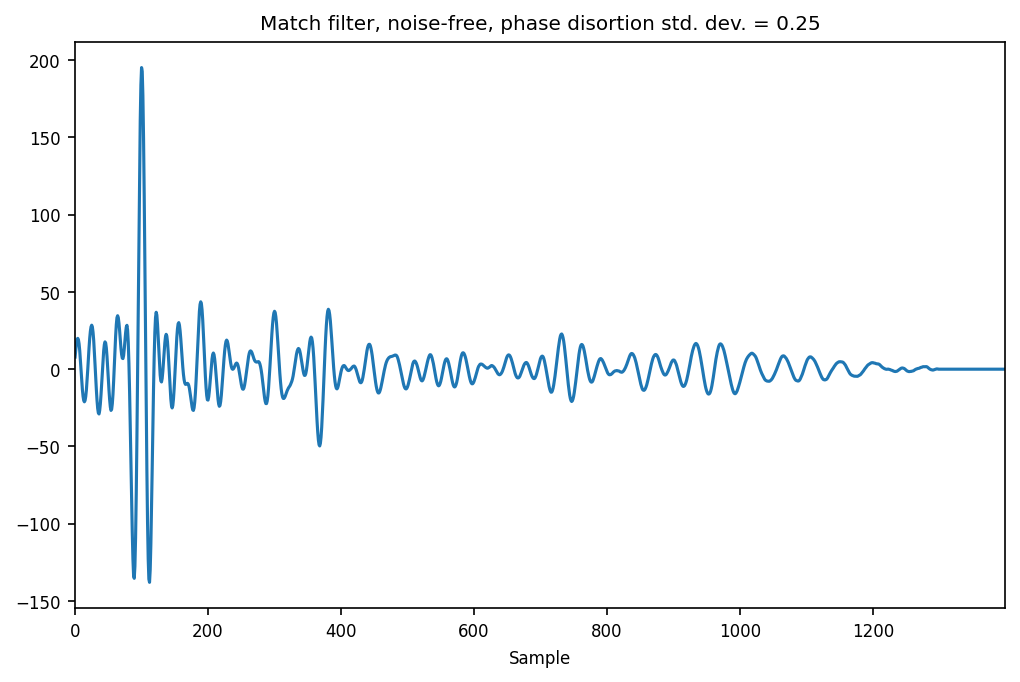

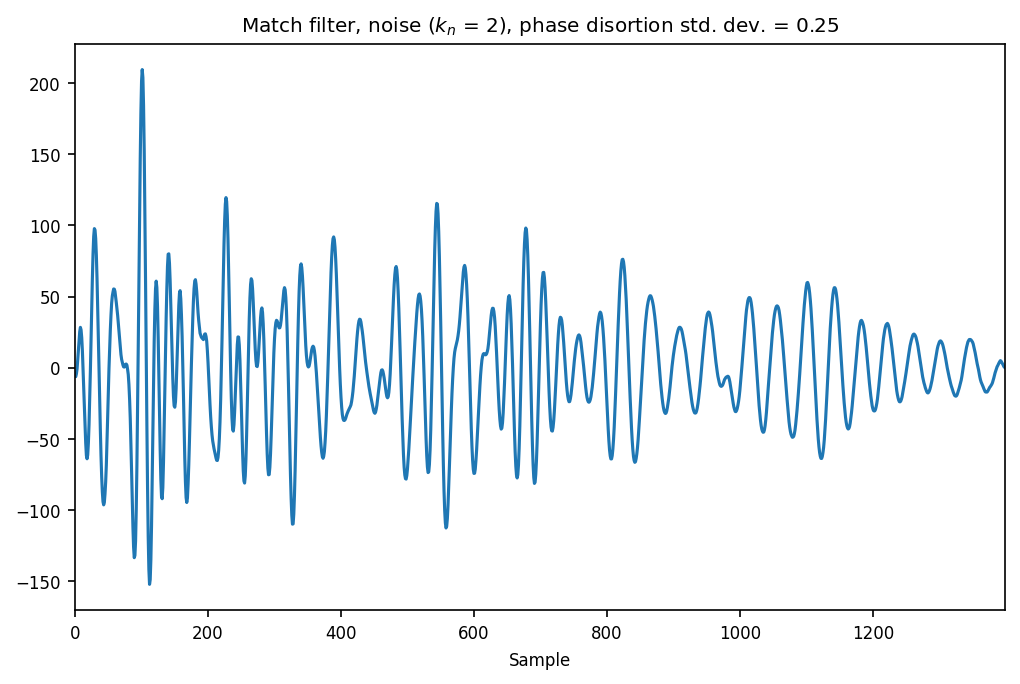

In [128]:
#--- generate signal
num_pad = 100
phase_distortion = 0.25
noise_factor = 2
signal, pilot = genSweep(f0=1000.0,f1=3000,T=24e-3,dt=1/50e3,num_pad=num_pad,phase_distortion=phase_distortion)
# plotResults(signal)

#--- match filtering
filt = pilot[:len(signal)]
pc_signal = correlate(signal,filt,mode='full')
plotResults(pc_signal[len(filt)-1-num_pad:],f'Match filter, noise-free, phase disortion std. dev. = {phase_distortion}')

#--- match filtering + noise
k_n = noise_factor
noise = np.random.normal(loc=0,scale=k_n*signal.max(),size=signal.size)
pc_signal_wn = correlate(signal+noise,filt,mode='full')
plotResults(pc_signal_wn[len(filt)-1-num_pad:],rf'Match filter, noise ($k_n$ = {k_n}), phase disortion std. dev. = {phase_distortion}')
# plotResults(pc_signal)